In [1]:
from tqdm import tqdm, trange
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')
rescale_size = 244
batch_size = 64

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [3]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((int(rescale_size * 1.25), int(rescale_size * 1.25))),
        transforms.RandomCrop(rescale_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((int(rescale_size * 1.25), int(rescale_size * 1.25))),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [4]:
train_dir = "/mnt/data/datasets/pics/train/train_dataset"
test_dir  = "/mnt/data/datasets/pics/test/ml_ozon_сounterfeit_test_images"

full_data = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'])

train_idx, valid_idx = train_test_split(list(range(len(full_data))), train_size=0.8)
dataset = {
    'train': torch.utils.data.Subset(full_data, train_idx),
    'val': torch.utils.data.Subset(full_data, valid_idx)
}

dataloaders = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=batch_size, shuffle=True, num_workers=8
    ),
    'val': torch.utils.data.DataLoader(
        dataset=dataset['val'], batch_size=batch_size, shuffle=False, num_workers=8
    ),
}

dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

In [5]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    start = time.time()

    best_mode_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], 'val': []}
    accs = {'train': [], 'val': []}

    pbar = trange(epochs, desc='Epoch')

    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.eval()

            curr_loss = 0.0
            curr_corrects = 0

            for data in tqdm(dataloaders[phase], desc=f'{phase} iter'):
                inputs, labels = data
                if torch.cuda.is_available():
                    inputs, labels = inputs.cuda(), labels.cuda()
                else:
                    inputs, labels = inputs, labels

                if phase == 'train':
                    optimizer.zero_grad()

                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    # print("Loss requires_grad:", loss.requires_grad)
                    # print("Loss grad_fn:", loss.grad_fn)
                    # print("Any param with grad:", any(p.requires_grad for p in model.parameters()))

                    loss.backward()
                    optimizer.step()

                curr_loss += loss.item()
                curr_corrects += int(torch.sum(preds == labels.data))
            epoch_loss = curr_loss / dataset_sizes[phase]
            epoch_acc = curr_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - start

    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    return model, losses, accs

In [6]:
def plot_metrics(losses, accs):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 2, 1)
    plt.plot(losses['train'])
    plt.plot(losses['val'])
    plt.title('loss')
    plt.legend(list(losses.keys()))

    plt.subplot(1, 2, 2)
    plt.plot(accs['train'])
    plt.plot(accs['val'])
    plt.title('accuracy')
    plt.legend(list(accs.keys()))

    plt.show()

In [7]:
def evaluate(model):
    model.eval()

    curr_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data

    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()

    output = model(inputs)
    _, preds = torch.max(output, 1)

    curr_correct += int(torch.sum(preds == labels))

    return curr_correct / dataset_sizes['val']

In [8]:
def predict(model, dataloaders_test):
    probs = []
    model.eval()
    with torch.no_grad():
        
        for inputs, y in tqdm(dataloaders_test):
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                
            preds = model(inputs).cpu()
            probs.append(preds)
            
    print(f'probs shape before softmax: {len(probs)}')
    probs = nn.functional.softmax(torch.cat(probs), dim=-1).numpy()
    print(f'probs shape after softmax: {probs.shape}')
    
    return probs

In [9]:
# предобученная модель
model = models.resnet18(pretrained=True)

# замораживаем все параметры
for param in model.parameters():
    param.requires_grad = False


num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_data.classes))

for param in model.fc.parameters():
    param.requires_grad = True

model.to(device)
print(device)
next(model.parameters()).device

model.fc

cpu


Linear(in_features=512, out_features=2, bias=True)

In [12]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model.parameters()), lr=3e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model, losses_resnet, accs_resnet = train_model(model, loss_func, optimizer, exp_lr_scheduler, epochs=15)

val Loss: 0.0030 Acc: 0.9352: 100%|██████████| 15/15 [16:41:46<00:00, 4007.11s/it]    

Training complete in 1001m 47s
Best val Acc: 0.9365


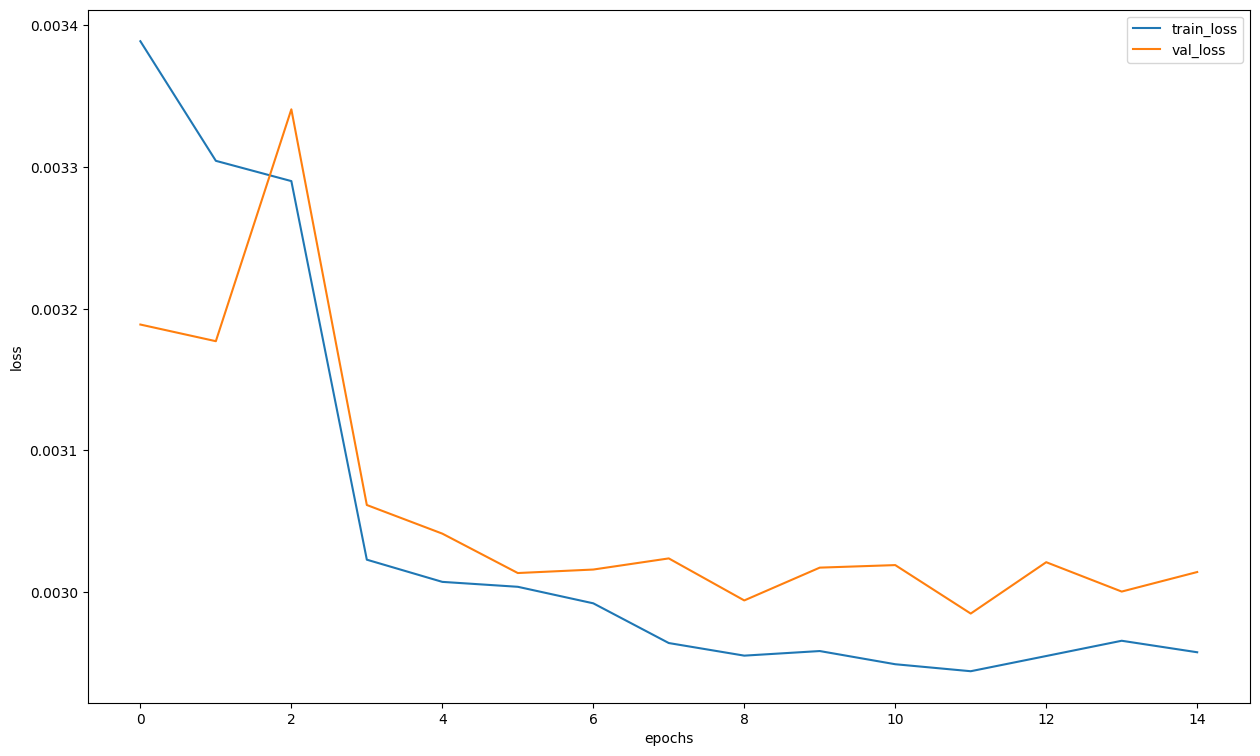

In [13]:
plt.figure(figsize=(15, 9))
plt.plot(losses_resnet['train'], label="train_loss")
plt.plot(losses_resnet['val'], label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

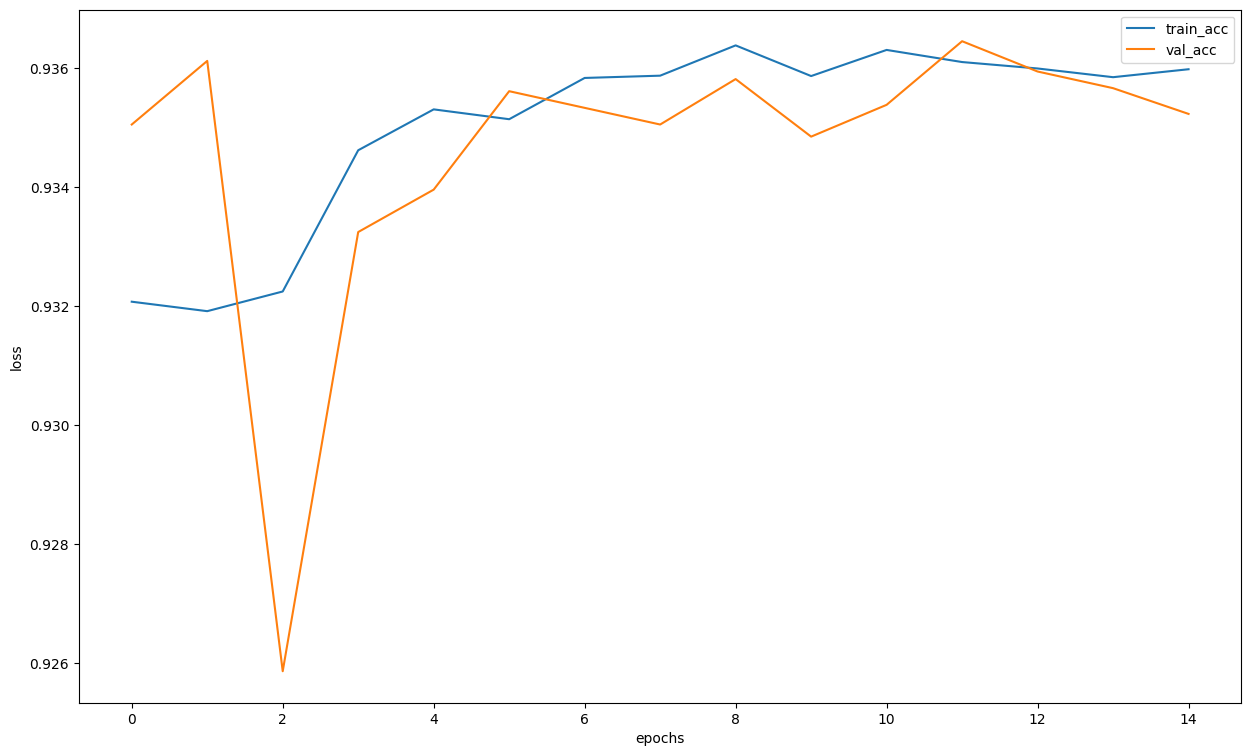

In [14]:
plt.figure(figsize=(15, 9))
plt.plot(accs_resnet['train'], label="train_acc")
plt.plot(accs_resnet['val'], label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [17]:
from sklearn.metrics import f1_score

def calculate_f1(model, dataloader, dataset_size):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    f1 = f1_score(all_labels, all_preds, average='micro')
    return f1

f1_val = calculate_f1(model, dataloaders['val'], dataset_sizes['val'])
print(f'F1 Score on validation dataset: {f1_val:.4f}')

F1 Score on validation dataset: 0.9360


In [16]:
torch.save(model, "model.pth")